In [2]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ZeroPadding2D, Add, UpSampling2D, Concatenate, Lambda, LeakyReLU # Стандартные слои Keras
from tensorflow.keras.regularizers import l2 # Регуляризатор l2
from tensorflow.keras.optimizers import Adam # Оптимизатор Adam
from tensorflow.keras.models import Model # Абстрактный класс Model
from PIL import Image, ImageDraw, ImageFont # Модули работы с изображениями
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb # Модули конвертации между RGB и HSV
from google.colab import files # Модуль работы с файловой системой google

import tensorflow.keras.backend as K # бэкенд Keras
import math # Импортируем модуль math
import pandas as pd # Пандас для работы с csv
import tensorflow as tf # TensorFlow
import numpy as np # numpy массивы
import matplotlib.pyplot as plt # графики
import os # модуль работы с файловой системой
import time # модуль работы со временем
import cv2

In [1]:
from google.colab import drive # подключаем гугл драйв диск для загрузки файлов
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Установка библиотеки OpenCV
!pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Раскадровка видео

In [ ]:
# Раскадрирование видео и сохранение кадров
video_path = "/content/drive/MyDrive/videoplayback2.mp4"
cap = cv2.VideoCapture(video_path)
count = 0
frame_interval = 3 * int(cap.get(cv2.CAP_PROP_FPS)) # интервал в 3 секунды

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    
    if count % frame_interval == 0:
        image_name = f"frame_{count}.jpg"
        image_path = f"/content/drive/MyDrive/{image_name}"
        cv2.imwrite(image_path, frame)
    
    count += 1

cap.release()

# Шаг 4: Сохранение изображений в Google Drive
from google.colab import drive
drive.mount('/content/drive')

image_folder_path = "/content/drive/MyDrive/"
image_save_folder_path = "/content/drive/MyDrive/Saved_Images/"

!mkdir -p "{image_save_folder_path}"
!cp "{image_folder_path}"frame*.jpg "{image_save_folder_path}"


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# YOLOv5. Используем фреймворк

In [4]:
TRAIN_DIR = '/content/drive/MyDrive/arm_detection/'   # полный путь к папке сохраним в переменной TRAIN_DIR

In [5]:
!unzip -q -o "/content/drive/MyDrive/arm_detection2.zip"  -d {TRAIN_DIR} # распакуем загруженный файл в подготовленный каталог при помощи команды unzip

In [6]:
!ls {TRAIN_DIR}

data.yaml  README.dataset.txt  README.roboflow.txt  train  valid


In [7]:
data_path = TRAIN_DIR+'data.yaml' #сохраним путь к файлу в отдельную переменную
!cat {data_path}

train: ../train/images
val: ../valid/images
test: ../test/images

nc: 3
names: ['gun', 'man with a gun', 'man']

roboflow:
  workspace: uai
  project: recognition-of-armed-people
  version: 10
  license: Public Domain
  url: https://universe.roboflow.com/uai/recognition-of-armed-people/dataset/10

In [8]:
!ls {TRAIN_DIR+'train'}

images	labels


In [9]:
!ls {TRAIN_DIR+'train'}/labels

101_jpg.rf.30eddb9fa07892ecc068151a8d3971a5.txt
102_jpg.rf.29923ca72d480db1e7dadc897fd958e8.txt
103_jpg.rf.c713f72ed7be647d5d1cc34a8655b342.txt
105_jpg.rf.c6559569424bd62b7f20385e80849bcb.txt
107_jpg.rf.a0392fa00ff4f497ce2ed32df45b387f.txt
108_jpg.rf.6e0e59cf65bfb0063b3313b3e69a9fd5.txt
109_jpg.rf.dd14633f056da0910130aa32e7ab7fa5.txt
10_mp4-2_jpg.rf.09b8176d412029bceb03053e8ba2efff.txt
10_mp4-3_jpg.rf.fdce36ad10dd54376e5ea026013eaaee.txt
10_mp4-7_jpg.rf.82fa7de7ae14342441a3321b8a3cb5a5.txt
110_jpg.rf.608f8f7cfe0ca9741169e9ebc0801cd5.txt
111_jpg.rf.1534204ed3c55bb344d98f8da0f7f9a7.txt
112_jpg.rf.c983581b7b458d64cb0d673cea56133b.txt
113_jpg.rf.d9b70febec2375a8b887e68bdc9ea624.txt
114_jpg.rf.a1c9554a259a09f7942b0eae72708099.txt
115_jpg.rf.f785da90c98c5364e63798f7eaa3a46b.txt
116_jpg.rf.b60a3bc410323202e1b76f461437ca3b.txt
117_jpg.rf.648fd7c1147268e904db0717a9b780e5.txt
118_jpg.rf.4b10e2d9dad621fe5628c340647a1a27.txt
119_jpg.rf.fb9dde7ad246a53471ce1c5fbc4bd657.txt
11_mp4-10_jpg.rf.22734b71

In [10]:
print(len(os.listdir(TRAIN_DIR+'train/images/')))
print(len(os.listdir(TRAIN_DIR+'train/labels/')))

1885
1885


In [11]:
lab_f_name = os.listdir(TRAIN_DIR+'train/labels/')[0] #возьмем имя первого файла из подкаталога labels
!cat {TRAIN_DIR+'train/labels/'+lab_f_name}

2 0.478787210584344 0.09366666666666668 0.031069459757442117 0.10384313725490196

In [12]:
# загрузка пакет TerraYolo
#!pip install --index-url https://test.pypi.org/simple/ --no-deps TerraYolo --upgrade
!pip install TerraYolo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [13]:
from TerraYolo.TerraYolo import TerraYoloV5 #Из модуля TerraYolo пакета TerraYolo импортируем класс TerraYoloV5

In [14]:
my_terra_yolov5 = TerraYoloV5(work_dir=TRAIN_DIR) #создаем экземпляр класса my_terra_yolov5

In [15]:
!ls {my_terra_yolov5.work_dir}

data.yaml  README.dataset.txt	train  yolov5
model.log  README.roboflow.txt	valid


In [16]:
my_terra_yolov5.count_labels(data_path) # проверим число объектов датасета

lab_dir /content/drive/MyDrive/arm_detection/train/labels
в каталоге /content/drive/MyDrive/arm_detection/train/labels найдены описания: [2606 3357 1881] классов: [0 1 2]
lab_dir /content/drive/MyDrive/arm_detection/valid/labels
в каталоге /content/drive/MyDrive/arm_detection/valid/labels найдены описания: [490 508 325] классов: [0 1 2]
каталог /content/drive/MyDrive/arm_detection/test/labels не найден


In [17]:
train_dict=dict()
train_dict['epochs'] = 5
train_dict['data'] = data_path #путь к описанию датасета

In [18]:
# в режиме 'train' запустим обучение с задаными параметрами
my_terra_yolov5.run(train_dict, exp_type='train') 

command python /content/drive/MyDrive/arm_detection/yolov5/train.py --epochs 5 --data /content/drive/MyDrive/arm_detection/data.yaml
train: weights=drive/MyDrive/arm_detection/yolov5/yolov5s.pt, cfg=, data=/content/drive/MyDrive/arm_detection/data.yaml, hyp=drive/MyDrive/arm_detection/yolov5/data/hyps/hyp.scratch-low.yaml, epochs=5, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=drive/MyDrive/arm_detection/yolov5/runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-169-geef637c Python-3.10.11 torch-2.0.1+cu118 CPU

hyperparamet

In [19]:
# познакомимся с каталогом с результатами экспериментов
!ls /content/my_yolov5/yolov5/runs

ls: cannot access '/content/my_yolov5/yolov5/runs': No such file or directory


In [20]:
# познакомимся с каталогом с результатами обучения
!ls /content/my_yolov5/yolov5/runs/train/

ls: cannot access '/content/my_yolov5/yolov5/runs/train/': No such file or directory


In [21]:
test_dict = dict()
test_dict['source'] = TRAIN_DIR+'/valid/images/' #так как в нашем датасете мы не подготовили тестовую выборку -  укажем путь к изображениям валидационной выборки
test_dict['conf'] = 0.5 # порог вероятности обнаружения объекта
test_dict['weights'] = my_terra_yolov5.exp_dict['train'][ #путь к весам модели
                                            'last_exp_path']+'/weights/best.pt'

my_terra_yolov5.run(test_dict, exp_type='test')

command python /content/drive/MyDrive/arm_detection/yolov5/detect.py --source /content/drive/MyDrive/arm_detection//valid/images/ --conf 0.5 --weights /content/drive/MyDrive/arm_detection/yolov5//runs/train//exp/weights/best.pt
detect: weights=['/content/drive/MyDrive/arm_detection/yolov5//runs/train//exp/weights/best.pt'], source=/content/drive/MyDrive/arm_detection//valid/images/, data=drive/MyDrive/arm_detection/yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=drive/MyDrive/arm_detection/yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-169-geef637c Python-3.10.11 torch-2.0.1+cu118 CPU

Fusing layers...
Model summary: 157 layers, 7018216 parameters, 0 gradients, 15.8 GFL

img_path /content/drive/MyDrive/arm_detection/yolov5//runs/detect//exp


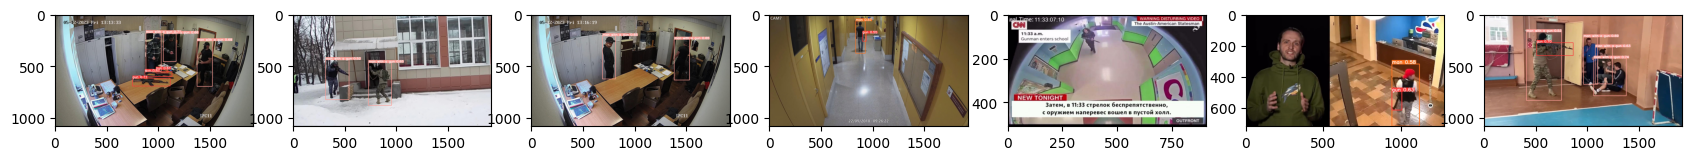

In [22]:
N_SAMPLES=7 # зафиксируем в константе число изображений
my_terra_yolov5.show_test_images(n_samples=N_SAMPLES, img_dir=None) #показать n_samples изображений